In [ ]:
! pip install networkx
! pip install matplotlib
! pip install pyvis

In [5]:
# part 1: parse step input file
import json
step_file_dict = json.load(open("test.json"))

simulation_steps = step_file_dict["steps"]
amount_of_devices = step_file_dict["devices"]
amount_of_wires = step_file_dict["wires"]

for step_index in range(simulation_steps):
  print("\nstep: " + str(step_index))
  step = step_file_dict["step-" + str(step_index)]
  
  # loop through each device's state in this step
  for device_index in range(amount_of_devices):
    device_state = step["d-" + str(device_index)]
    print("device-" + str(device_index) + " state: " + device_state)

  # loop through each wire's state in this step
  for wire_index in range(amount_of_wires):
    wire_state = step["w-" + str(wire_index)]["STATE"]
    wire_data = step["w-" + str(wire_index)]["DATA"]
    print("wire-" + str(wire_index) + " state: " + wire_state + " data: " + wire_data)


step: 0
device-0 state: IDLE
device-1 state: IDLE
wire-0 state: EMPTY data: 
wire-1 state: EMPTY data: 

step: 1
device-0 state: IDLE
device-1 state: IDLE
wire-0 state: EMPTY data: 
wire-1 state: EMPTY data: 

step: 2
device-0 state: IDLE
device-1 state: IDLE
wire-0 state: EMPTY data: 
wire-1 state: EMPTY data: 

step: 3
device-0 state: IDLE
device-1 state: IDLE
wire-0 state: EMPTY data: 
wire-1 state: EMPTY data: 

step: 4
device-0 state: IDLE
device-1 state: IDLE
wire-0 state: EMPTY data: 
wire-1 state: EMPTY data: 

step: 5
device-0 state: IDLE
device-1 state: IDLE
wire-0 state: EMPTY data: 
wire-1 state: EMPTY data: 

step: 6
device-0 state: IDLE
device-1 state: IDLE
wire-0 state: EMPTY data: 
wire-1 state: EMPTY data: 

step: 7
device-0 state: IDLE
device-1 state: IDLE
wire-0 state: EMPTY data: 
wire-1 state: EMPTY data: 

step: 8
device-0 state: IDLE
device-1 state: IDLE
wire-0 state: EMPTY data: 
wire-1 state: EMPTY data: 

step: 9
device-0 state: IDLE
device-1 state: IDLE
wire

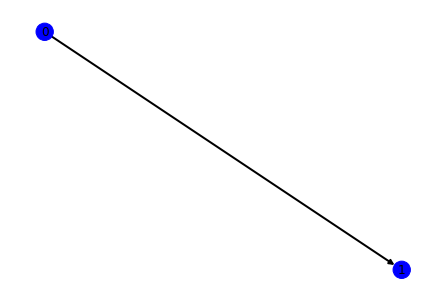

In [6]:
# %matplotlib inline
from matplotlib import pyplot as plt, animation
from matplotlib import rc
from IPython.core.display import display, HTML
import networkx as nx
import random


# set up animation figure
rc('animation', html='jshtml')
fig = plt.figure()

# create and populate graph
G = nx.DiGraph()
G.add_node(0)
G.add_node(1)
G.add_edge(0,1, color='green', weight=4)
pos = nx.spring_layout(G) # keep position of nodes


def animate(frame):
  # animate a frame based on the state
  fig.clear()
  
  device_color_map = []
  wire_color_dict = G.edges()

  # get the step for this frame
  step_index = frame
  step = step_file_dict["step-" + str(step_index)]
  
  # loop through each device's state in this step
  for device_index in range(amount_of_devices):
    device_state = step["d-" + str(device_index)]
    if(device_state == "IDLE"):
      device_color_map.append("blue")
    else:
      device_color_map.append("green")

  # loop through each wire's state in this step
  for wire_index in range(amount_of_wires):
    wire_state = step["w-" + str(wire_index)]["STATE"]
    wire_data = step["w-" + str(wire_index)]["DATA"]
    if(wire_state == "EMPTY"):
      G[0][1]['weight'] = 2
    else:
      G[0][1]['weight'] = 6
      print("w-" + str(wire_index) + " has data of " + wire_data)

  # get weights for wires
  edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())

  nx.draw(G, pos=pos, node_color=device_color_map, width=weights, with_labels=True)

ani = animation.FuncAnimation(fig, animate, frames=simulation_steps, interval=1000, repeat=True)
ani